# In this practical we wil look at how we can perform a simple Random Forest Classification to detect green and non-green areas in Wuerzburg, Germany.

### To hande raster and spatial data we will use rasterio and geopandas. To classify green areas we will use scikit-learn library.

We start by importing all the relevant libraries.

In [37]:
import rasterio
import rasterio.mask
from rasterio.plot import plotting_extent
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

### To classifica green/non-green areas we will use a single data NDVI dataset created using Sentinel-2 datasets from July 2021.

Therefore, we will first read in the NDVI dataset with the rasterio, we will then check how the data structure looks like, minmum and maximum values as well as plot the dataset.

In [38]:
# Open the dataset

with rasterio.open('C:/Users/ismayiir/Desktop/R_Github/Python/NDVI_07.tif') as src:
    ndvi = src.read(1)
    affine = src.transform
    extent = plotting_extent(src) # we might need it later for plotting
    
print(ndvi.shape)

(1498, 1027)


In [20]:
# Print the first 5 rows of the ndvi array

print(ndvi[:5])

[[0.8376168  0.8277975  0.71292216 ... 0.83237714 0.8364486  0.8192208 ]
 [0.8167605  0.8525684  0.8227848  ... 0.85095716 0.8413965  0.75566816]
 [0.8196771  0.8633846  0.8521472  ... 0.8412098  0.8089109  0.56186724]
 [0.8337022  0.86326766 0.8497076  ... 0.82421076 0.6586764  0.31666198]
 [0.8652084  0.8785639  0.8872877  ... 0.6795953  0.3830488  0.21714923]]


In [33]:
# Print the minimum and the maximum values

print('Min NDVI:', ndvi.min())
print('Max NDVI:', ndvi.max())

# Minimum ndvi value suggests that there might be improperly handled no-data values or outliers in the dataset

Min NDVI: -1.01
Max NDVI: 1.0


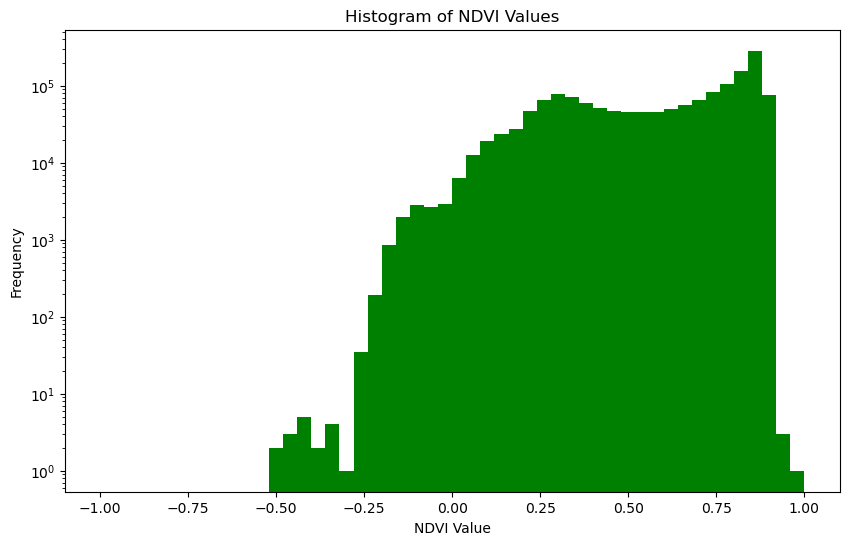

In [22]:
# Let's plot the histogram of value distribution

# Flatten the NDVI data to a 1D array for histogram plotting
ndvi_flat = ndvi.ravel()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(ndvi_flat, bins=50, range=(-1,1), color='green')  
plt.title('Histogram of NDVI Values')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.yscale('log', nonpositive='clip')  # Log scale to better visualize the distribution of values
plt.show()

##### NDVI values range between -1 and +1, where values closer to +1 indicate dense and heatly vegetation. However, we have some outliers in the dataset which we would like to get rid off. In this particula case we can replace all the outliers with a value not too of from the -1. Depending on the goal of the analysis, you might prefer to take a different action here like replacing with -9999 or NaN or something else.

In [23]:
# Mask out invalid values
ndvi[ndvi < -1] = -1.01  

# Re-check the minimum and maximum to ensure the masking worked
print('Adjusted Min NDVI:', np.nanmin(ndvi))
print('Adjusted Max NDVI:', np.nanmax(ndvi))

Adjusted Min NDVI: -1.01
Adjusted Max NDVI: 1.0


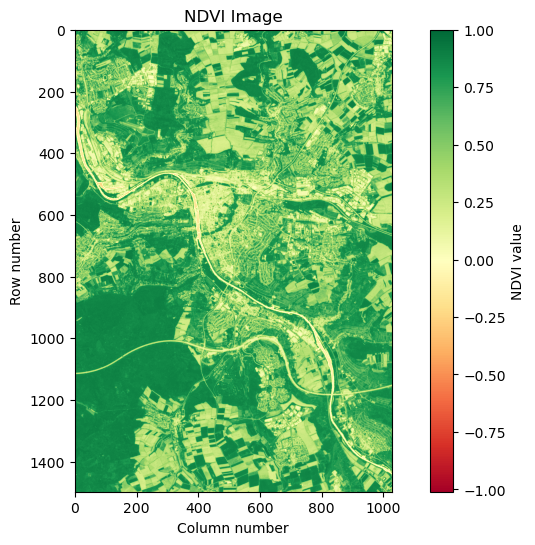

In [24]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Display the data
plt.imshow(ndvi, cmap='RdYlGn') 
plt.colorbar(label='NDVI value')
plt.title('NDVI Image')
plt.xlabel('Column number')
plt.ylabel('Row number')

# Show the plot
plt.show()

### Now lets load the training data.

Training data is a point shapefile that has one column called "class". This column stores values '1' for green areas and '0' for non-green areas. Similarly to the NDVI, we can check for besic descriptors and plot it.

In [11]:
# Load the point shapefile
points = gpd.read_file('C:/Users/ismayiir/Desktop/R_Github/Python/TrainingData_Wuerz.shp')

In [12]:
# Load the point shapefile
points = gpd.read_file('C:/Users/ismayiir/Desktop/R_Github/Python/TrainingData_Wuerz.shp')

In [13]:
print(points.head())

   class                        geometry
0      1  POINT (565139.208 5513247.887)
1      1  POINT (565456.021 5513397.829)
2      1  POINT (564852.625 5513245.469)
3      1  POINT (565482.624 5513085.853)
4      1  POINT (565102.931 5513065.296)


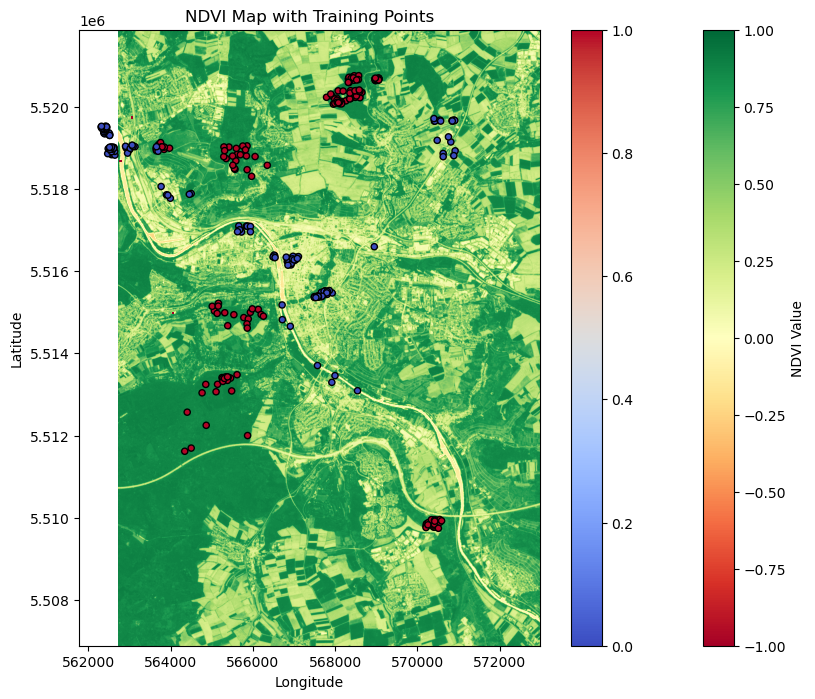

In [39]:
# Plot the points over the NDVI raster

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(ndvi, cmap='RdYlGn', extent=extent, vmin=-1, vmax=1)  # Set color range from -1 to 1
plt.colorbar(im, label="NDVI Value")  # Add colorbar

# Overlay training points
points.plot(ax=ax, column="class", cmap="coolwarm", markersize=20, edgecolor='black', legend=True)

# Add labels and title
ax.set_title("NDVI Map with Training Points")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

As we can see in the plot, there are some points outside of the NDVI extent. This might be an issue during the classification, therefore we will have to eliminate them later on.

### Now that we have both the NDVI dataset and the training dataset, we can start preparing data for the classification.

#### The general procedure is as follows: 
1. Extract NDVI valuess for each training point
2. Create training and testing datasets
3. Assess the model accuracy
4. Classify the whole NDVI raster, plot, and save the results

In [25]:
# Function to extract NDVI using point geometry
def extract_ndvi_value(point, raster, affine):
    row, col = ~affine * (point.x, point.y)
    
    # Check whether there are any points outside of the extent of the ndvi
    if (0 <= row < raster.shape[0]) and (0 <= col < raster.shape[1]):
        return raster[int(row), int(col)]
    return None  # Return None or a default value for out-of-extent points

# Apply the function to extract NDVI
points['ndvi_value'] = points.geometry.apply(lambda geom: extract_ndvi_value(geom, ndvi, affine))

In [26]:
# 'class' is the column with labels in the shapefile
X = points['ndvi_value'].values.reshape(-1, 1)
y = points['class'].values

# Handle possible NaN values in X 
valid_indices = ~np.isnan(X[:, 0])  # Filter out rows where NDVI is NaN
X = X[valid_indices]
y = y[valid_indices]

In [27]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [28]:
# Check for the accuracy measures
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=clf.oob_score_ * 100))

Accuracy: 0.5775401069518716
Our OOB prediction of accuracy is: 59.49367088607595%


Previously we eliminated outliers from the NDVI dataset. However, there might be still some values missing. We have to eliminate those as well. Therefore we replace them with -9999 and then create a mask  that does not contain these values.

In [29]:
no_data = -9999  
valid_mask = ndvi_flat != no_data  

In [30]:
# Prepare valid NDVI values for prediction
ndvi_valid = ndvi_flat[valid_mask].reshape(-1, 1)  

# Predict classes for the valid NDVI values
predicted_classes = model.predict(ndvi_valid)

In [31]:
# Create an empty array to store the full classification results
classified_raster = np.full(ndvi_flat.shape, no_data)  # Initialize with no-data values
classified_raster[valid_mask] = predicted_classes  # Insert predictions back into the correct locations

# Reshape back to the original raster dimensions
classified_raster = classified_raster.reshape(ndvi.shape)

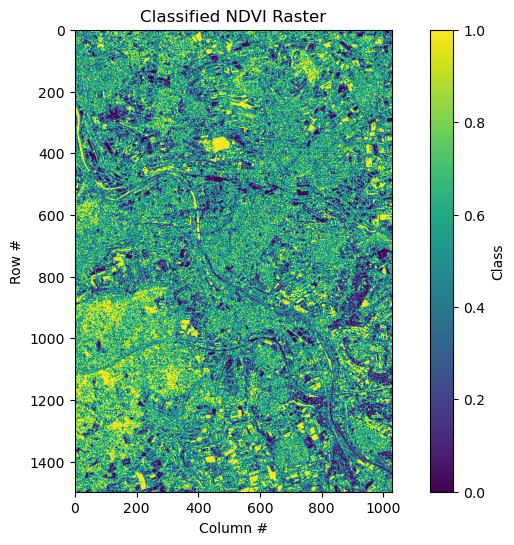

In [32]:
# Plotting the classified raster
plt.figure(figsize=(10, 6))  
plt.imshow(classified_raster, cmap='viridis')  
plt.colorbar(label='Class') 
plt.title('Classified NDVI Raster')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

In [40]:
# Save the result as a new raster file
with rasterio.open(
    'C:/Users/ismayiir/Desktop/R_Github/Python/Classified_NDVI_07.tif', 'w',
    driver='GTiff',
    height=classified_raster.shape[0],
    width=classified_raster.shape[1],
    count=1,  # one band
    dtype=classified_raster.dtype,
    crs=src.crs,
    transform=affine
) as dst:
    dst.write(classified_raster, 1)